In [26]:
import seaborn as sns
import pandas as pd
import wandb

In [27]:
# Functions

def load_sweeps(sweeps, config_save, max_samples_per_run):
    filter_dict = {"sweep":{"$in":sweeps}}
    api = wandb.Api(timeout=30)
    entity, project = "ltecot", "quantum_optimization"
    runs = api.runs(entity + "/" + project, filters=filter_dict)
    summary_list, config_list, name_list = [], [], []
    runs_list = []
    for run in runs:
        run_data = run.history(samples=max_samples_per_run)
        remove_columns = [k for k in run_data.columns.values if k.startswith('_')]
        run_data = run_data.drop(columns=remove_columns)
        save_from_config = dict((k, run.config[k]) for k in config_save)
        save_from_config["run_name"] = run.name
        run_data = run_data.assign(**save_from_config)
        runs_list.append(run_data)
        print("Loaded " + run.name)
    runs_df = pd.concat(runs_list)
    return runs_df

# Filter for rows that are the final step of each run
def get_final_values(df):
    last_step = df['step'].max()
    return df.loc[df['step'] == last_step]

In [39]:
# Load experiment runs
# Don't worry if this hangs, it can take a very long time
# Loading too many might overload your machine, so be careful when doing so

max_samples_per_run = 5000
config_save = ["optimizer", "rand_seed"]
# Run Processing
# Stuff like changing optimizer names to be prettier
replace_dict = {"adamspsa" : "adamSPSA",
                "pl_qnspsa" : "QNSPSA",
                "qnspsa" : "QNSPSA",
                "2spsa" : "2-SPSA",
                "xnes" : "xNES",
                "snes" : "sNES",
                "spsa" : "SPSA",
                "ges" : "GES",
               }
# So we can have consistent colors per optimizer : 
optimizer_palette ={'SPSA':'#4c72b0',
                    'adamSPSA':'#dd8452',
                    'QNSPSA':'#55a868',
                    '2-SPSA':'#c44e52',
                    'xNES':'#8172b3',
                    'sNES':'#937860',
                    'GES':'#da8bc3',}
# To set order of plotting in boxplot / legend in convergence plots
optimizer_order = ['SPSA','adamSPSA','QNSPSA','2-SPSA','xNES','sNES','GES']

# -----------------------------------------------------------

# ising_1d_sweeps = ["ynq6zj7a","grtaezvx","osdq0v2h","8le1ihts","v3zzxoqv","b07fcmu0","6f90a439"]
# ising_1d_runs = load_sweeps(ising_1d_sweeps, config_save, max_samples_per_run)
# ising_1d_runs = ising_1d_runs.replace(replace_dict)

# random_ham_sweeps = ["8b8lwlv8","22xzl1bd","dzvcaan7","ho3hfydo","hcsc8mab","8nbjvao2","wmmtqzko"]
# random_ham_runs = load_sweeps(random_ham_sweeps, config_save, max_samples_per_run)
# random_ham_runs = random_ham_runs.replace(replace_dict)

# heisenburg_2d_sweeps = ["3eopljqi","p2a0wxah","k705w87h","s1jicn6x","dmlpp14c","6tcfsh92","ftlb19yf"]
# heisenburg_2d_runs = load_sweeps(heisenburg_2d_sweeps, config_save, max_samples_per_run)
# heisenburg_2d_runs = heisenburg_2d_runs.replace(replace_dict)

qcbm_gen_sweeps = ["bjennlze","s6idzkbv","2j1p202e","bu34865l","leqxvsni","k8mltsz3","p2onug5z"]
qcbm_gen_runs = load_sweeps(qcbm_gen_sweeps, config_save, max_samples_per_run)
qcbm_gen_runs = qcbm_gen_runs.replace(replace_dict)

# rand_gen_sweeps = ["84e9cuqw", "a2slzesk", "wng8b0qb", "8zt1e5fo", "myazxi2c", "hsyrrsew", "s8rk9zse"]
# rand_gen_runs = load_sweeps(rand_gen_sweeps, config_save, max_samples_per_run)
# rand_gen_runs = rand_gen_runs.replace(replace_dict)


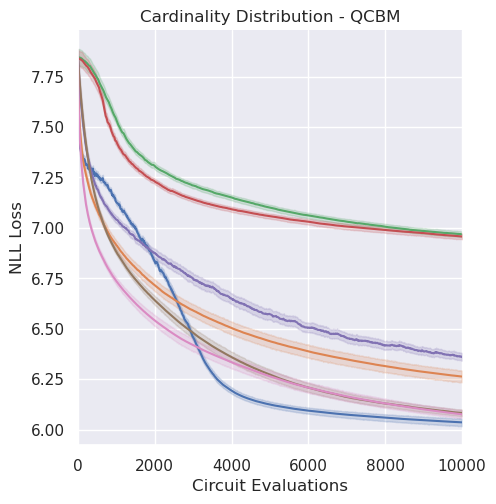

In [42]:
# Convergence plots

# ----- Input Properties -----

# curr_data, x_data, x_lim, x_label, y_label, title = ising_1d_runs, "step", 500, "Step", "Energy", "1D Ising"
# curr_data, x_data, x_lim, x_label, y_label, title = ising_1d_runs, "num_shots", 1000, "Circuit Evaluations", "Energy", "1D Ising"
# curr_data, x_data, x_lim, x_label, y_label, title = random_ham_runs, "step", 500, "Step", "Energy", "Randomized Hamiltonian"
# curr_data, x_data, x_lim, x_label, y_label, title = random_ham_runs, "num_shots", 1000, "Circuit Evaluations", "Energy", "Randomized Hamiltonian"
# curr_data, x_data, x_lim, x_label, y_label, title = heisenburg_2d_runs, "step", 2000, "Step", "Energy", "2D Heisenburg"
# curr_data, x_data, x_lim, x_label, y_label, title = heisenburg_2d_runs, "num_shots", 4000, "Circuit Evaluations", "Energy", "2D Heisenburg"
# curr_data, x_data, x_lim, x_label, y_label, title = qcbm_gen_runs, "step", 5000, "Step", "NLL Loss", "Cardinality Distribution - QCBM"
curr_data, x_data, x_lim, x_label, y_label, title = qcbm_gen_runs, "num_shots", 10000, "Circuit Evaluations", "NLL Loss", "Cardinality Distribution - QCBM"
# curr_data, x_data, x_lim, x_label, y_label, title = rand_gen_runs, "step", 2500, "Step", "NLL Loss", "Random Distribution - Random Circuit"
# curr_data, x_data, x_lim, x_label, y_label, title = rand_gen_runs, "num_shots", 5000, "Circuit Evaluations", "NLL Loss", "Random Distribution - Random Circuit"

# remove_legend = False
remove_legend = True

# Filter, for sub-sampling the data if seaborn can't handle it all
# step_filter_freq = 1
step_filter_freq = 5
# step_filter_freq = 100

# ----------------------------

sns.set_theme()
# sns.set_context("paper")

# ax = sns.relplot(data=curr_data, x="step", y="loss", hue="optimizer", kind="line", errorbar="sd")
# ax = sns.relplot(data=curr_data, x="step", y="loss", hue="optimizer", kind="line", errorbar=None)

filter_inds = ((curr_data["step"] % step_filter_freq == 0) & (curr_data[x_data] <= x_lim)) | (curr_data[x_data] == x_lim-1)
curr_data = curr_data[filter_inds]
ax = sns.relplot(data=curr_data, x=x_data, y="loss", hue="optimizer", kind="line", palette=optimizer_palette, hue_order=optimizer_order)
ax.set(xlim=(0,x_lim), xlabel=x_label, ylabel=y_label, title=title)
if remove_legend:
    ax._legend.remove()
else:
    ax._legend.set_title("Optimzer")

          loss  step  num_shots optimizer  rand_seed          run_name
4999  6.841333  4999      34993    QNSPSA       6133   royal-sweep-100
4999  6.825579  4999      34993    QNSPSA       9708    fresh-sweep-99
4999  6.592256  4999      34993    QNSPSA       6625     fast-sweep-98
4999  6.698652  4999      34993    QNSPSA       7125    lemon-sweep-97
4999  6.751493  4999      34993    QNSPSA       3541  dutiful-sweep-96
...        ...   ...        ...       ...        ...               ...
4999  5.886216  4999       9998      SPSA       4117     eager-sweep-5
4999  6.096991  4999       9998      SPSA       4626    unique-sweep-4
4999  6.068006  4999       9998      SPSA       5123      true-sweep-3
4999  6.027739  4999       9998      SPSA       6145      mild-sweep-2
4999  6.037446  4999       9998      SPSA       5632     eager-sweep-1

[700 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 4999 to 4999
Data columns (total 6 columns):
 #   Column     

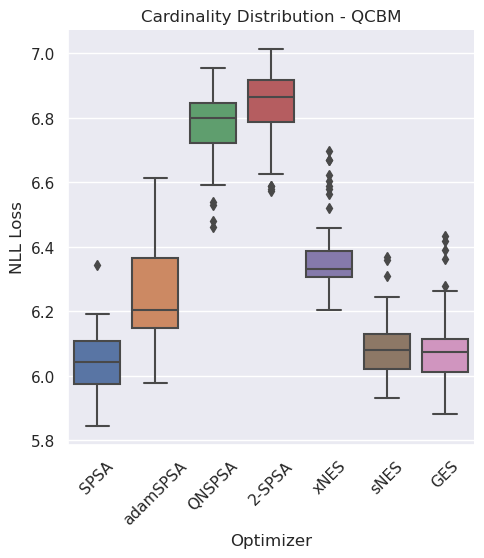

In [40]:
# Box / Violin Plots of converged results

# ----- Input Properties -----

# curr_data, title, y_label = ising_1d_runs, "1D Ising", "Energy"
# curr_data, title, y_label = random_ham_runs, "Randomized Hamiltonian", "Energy"
# curr_data, title, y_label = heisenburg_2d_runs, "2D Heisenburg", "Energy"
curr_data, title, y_label = qcbm_gen_runs, "Cardinality Distribution - QCBM", "NLL Loss"
# curr_data, title, y_label = rand_gen_runs, "Random Distribution - Random Circuit", "NLL Loss"

print(get_final_values(curr_data))

# ----------------------------

sns.set_theme()
# sns.set_context("paper")
x_label = 'Optimizer'

# sns.catplot(data=final_data, x="optimizer", y="loss", kind="boxen")
# sns.catplot(data=final_data, x="optimizer", y="loss", kind="violin")
# sns.catplot(data=final_data, x="optimizer", y="loss", kind="violin", inner="stick", bw=0.25, cut=0)

final_data = get_final_values(curr_data)
print(final_data.info())
ax = sns.catplot(data=final_data, x="optimizer", y="loss", kind="box", 
                 palette=optimizer_palette, order=optimizer_order)
ax.set(xlabel=x_label, ylabel=y_label, title=title)
ax.tick_params(axis='x', rotation=45)

In [22]:
# Other random testing / debugging

step_filter_freq = 3
x_lim = 2500
filter_inds = ((rand_gen_runs['step'] % step_filter_freq == 0) & (rand_gen_runs['step'] <= x_lim)) | (rand_gen_runs['step'] == x_lim-1)
# filter_inds = (rand_gen_runs['step'] % 5 == 0) | (rand_gen_runs['step'] == rand_gen_runs['step'].max())
print(filter_inds.iloc[:2500])
# curr_data = rand_gen_runs[filter_inds]
# print(curr_data)

# optimizer_order = ['SPSA','adamSPSA','QNSPSA','2-SPSA','xNES','sNES','GES']

# print(sns.color_palette().as_hex())

# optimizer_palette ={'SPSA':'#4c72b0',
#                     'adamSPSA':'#dd8452',
#                     'QNSPSA':'#55a868',
#                     '2-SPSA':'#c44e52',
#                     'xNES':'#8172b3',
#                     'sNES':'#937860',
#                     'GES':'#da8bc3',}

# print(random_ham_runs)

# # Apparently .history() method does adaptive sampling, so need scan_history() for everything?
# sweeps = ["3eopljqi"]
# filter_dict = {"sweep":{"$in":sweeps}}
# api = wandb.Api()
# entity, project = "ltecot", "quantum_optimization"
# runs = api.runs(entity + "/" + project, filters=filter_dict)
# summary_list, config_list, name_list = [], [], []
# runs_list = []
# for run in runs:
#     run_data = run.history(samples=5000)
#     print(run_data)
#     break

0        True
1       False
2       False
3        True
4       False
        ...  
2495    False
2496     True
2497    False
2498    False
2499     True
Name: step, Length: 2500, dtype: bool
